In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep 18 17:21:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    28W /  70W |  14586MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# https://github.com/leondgarse/keras_efficientnet_v2
!pip install -U keras-efficientnet-v2

In [ ]:
import keras_efficientnet_v2
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

In [ ]:
data_dir = "/content/drive/MyDrive/food"

batch_size = 256
imgSize = 224

splitRate = 0.2

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, seed=123, subset="training", validation_split=splitRate,
  image_size=(imgSize, imgSize), batch_size=batch_size
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, seed=123, subset="validation", validation_split=splitRate,
  image_size=(imgSize, imgSize), batch_size=batch_size
)

labArr = train_ds.class_names
classNum = len(train_ds.class_names)
print(train_ds.class_names)

Found 908 files belonging to 4 classes.
Using 727 files for training.
Found 908 files belonging to 4 classes.
Using 181 files for validation.
['SatayBeefNoodle', 'SingaporeStir-friedNoodles', 'Stir-friedBeefNoodle', 'fuknirice']


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
  ]
)

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(imgSize, imgSize),
  layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
])

In [ ]:
expendRound = 2
temp_ds = train_ds
for i in range(expendRound):
    train_ds = train_ds.concatenate(temp_ds)

#train_ds = train_ds.map(lambda image,label:(data_augmentation(image),label))

train_ds = train_ds.map(lambda image,label:(resize_and_rescale(image),label))
valid_ds = valid_ds.map(lambda image,label:(resize_and_rescale(image),label))

train_ds_Conbine = tf.data.Dataset.zip((train_ds, train_ds))

In [ ]:
# Cutmix distribution
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

# Cutmix box generator
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = imgSize * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = imgSize * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=imgSize, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=imgSize, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, imgSize)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, imgSize)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, imgSize)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, imgSize)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w

def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, imgSize, imgSize
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, imgSize, imgSize
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (imgSize * imgSize)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    #label = lambda_value * label1 + (1 - lambda_value) * label2

    return image, label1

In [ ]:
train_ds_cmu = train_ds_Conbine.map(cutmix)

# plt.figure(figsize=(10, 10))

# for images, labels in train_ds_cmu.take(1):
#   labelArr = labels.numpy()
#   for i in range(12):
#     ax = plt.subplot(3, 4, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title( labArr[labelArr[i]] )
#     plt.axis("off")

# plt.show()

In [ ]:
baseModel = keras_efficientnet_v2.EfficientNetV1B0(pretrained="noisy_student", num_classes=classNum, drop_connect_rate=0.4)

baseModel.trainable = True
print("Layers count", len(baseModel.layers))

fine_tune_at = int( len(baseModel.layers) * 0.2) # 20
for layer in baseModel.layers[:fine_tune_at]:
  layer.trainable = False
  
epochsRound = 15
base_learning_rate = 0.0001

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

baseModel.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = baseModel.fit(train_ds_cmu, epochs=epochsRound, validation_data=valid_ds, callbacks=[model_checkpoint_callback] )

test_loss, test_acc = baseModel.evaluate(valid_ds, verbose=2)
print(test_acc)


now = datetime.now()
current_time = now.strftime("%b-%d-%Y_%H:%M:%S")
srt = "/content/drive/MyDrive/savedModel/" + "effV1B0" + current_time + ".h5"

baseModel.load_weights(checkpoint_filepath)
baseModel.save(srt)

>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv1-b0-noisy_student.h5
Layers count 249


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


9/9 [==============================] - 33s 2s/step - loss: 1.3837 - accuracy: 0.3022 - val_loss: 1.2774 - val_accuracy: 0.4199
Epoch 2/15
9/9 [==============================] - 18s 2s/step - loss: 1.2979 - accuracy: 0.4191 - val_loss: 1.0769 - val_accuracy: 0.6740
Epoch 3/15
9/9 [==============================] - 18s 2s/step - loss: 1.1616 - accuracy: 0.5397 - val_loss: 0.8865 - val_accuracy: 0.8122
Epoch 4/15
9/9 [==============================] - 18s 2s/step - loss: 0.9752 - accuracy: 0.6864 - val_loss: 0.6563 - val_accuracy: 0.8785
Epoch 5/15
9/9 [==============================] - 18s 2s/step - loss: 1.0050 - accuracy: 0.6094 - val_loss: 0.5495 - val_accuracy: 0.8895
Epoch 6/15
9/9 [==============================] - 18s 2s/step - loss: 0.9975 - accuracy: 0.6158 - val_loss: 0.5045 - val_accuracy: 0.8840
Epoch 7/15
9/9 [==============================] - 18s 2s/step - loss: 0.8049 - accuracy: 0.7088 - val_loss: 0.4874 - val_accuracy: 0.8840
Epoch 8/15
9/9 [=============================

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


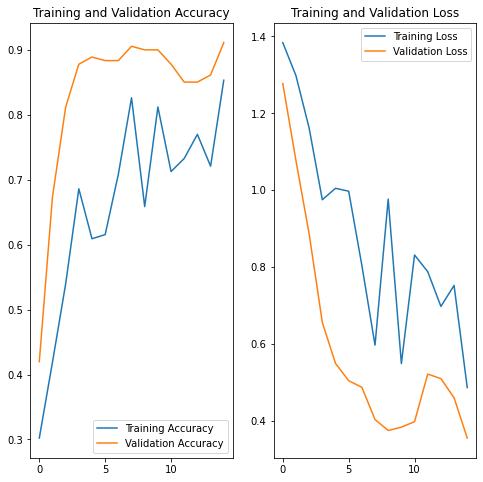

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochsRound)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# References  

1. Keras EfficientNetV2:  
https://github.com/leondgarse/keras_efficientnet_v2  
2. Transfer learning and fine-tuning  
https://www.tensorflow.org/tutorials/images/transfer_learning?hl=zh-tw  
3. CutMix data augmentation for image classification:  
https://keras.io/examples/vision/cutmix/ 
